### GradCAM (Gradient class activation mappinng)

这个版本主要用来了解制作Grad_Cam的过程，并没有特意封装

每行代码几乎都有注解

---


首先看到整个Grad CAM的生成是由下面的公式进行

>$L_{Grad-CAM}^c = ReLU(\sum_k\alpha^c_kA^k)$


我们可以发现到代码函数GradCam()最终生成的cam 就是公式中的 $RELU (\alpha_{k}^{c} A^k)$，就是目标层

为什么要将目标层定在Relu层呢？ 我们假设分类的类别是"C"这个类，**所以relu通常输出的是对类别C有作用的正值**，取这层才能将类别C的特征明显取出来，其余负值就相当于是其他类别A , B, D ...etc等等的了

<br>
<br>
<br>

而函数最下面有一个利用for loop的方式将relu层输出的平均weights（要先经由类别C的反向传播才能求得） 以及

Relu层输出的feature map 做 线性组合运算，也就是公式中的 $\alpha_{k}^{c} A^k$

<br>
<br>

$\alpha_{k}^{c}$  = 基于类别C反向传播后，relu层的的梯度
    
$A^k$ = relu目标层的feature map A, k 表示深度 这边是512



最终，我们将目标层平均权重乘上目标层feature map的结果放到空白的map上就是我们要的结果CAM

然后将CAM叠加到原图上就能清楚的显示目标层所提取的特征对应原图的哪个位置了


<br>
<br>
<br>
<br>
<br>
<mark>注意一下，代码中说的目标层就是我们锁定的VGG16中的第29层relu层</mark>



论文连接: https://arxiv.org/pdf/1610.02391v1.pdf

In [1]:
import torch as t
from torchvision import models
import cv2
import sys
import numpy as np
import matplotlib.pyplot as plt


In [2]:
class FeatureExtractor():
    """
    1. 提取目标层特征
    2. register 目标层梯度
    """
    def __init__(self, model, target_layers):
        self.model = model
        self.model_features = model.features
        self.target_layers = target_layers
        self.gradients = list()
    def save_gradient(self, grad):
        self.gradients.append(grad)
    def get_gradients(self):
        return self.gradients
    def __call__(self, x):
        target_activations = list()
        self.gradients = list()
        for name, module in self.model_features._modules.items(): #遍历的方式遍历网络的每一层
            x = module(x) #input 会经过遍历的每一层
            if name in self.target_layers: #设个条件，如果到了你指定的层， 则继续
                x.register_hook(self.save_gradient) #利用hook来记录目标层的梯度
                target_activations += [x] #这里只取得目标层的features
        x = x.view(x.size(0), -1) #reshape成 全连接进入分类器
        x = self.model.classifier(x)#进入分类器
        return target_activations, x,

        
def preprocess_image(img):
    """
    预处理层
    将图像进行标准化处理
    """
    mean = [0.485, 0.456, 0.406] 
    stds = [0.229, 0.224, 0.225]
    preprocessed_img = img.copy()[:, :, ::-1] # BGR > RGB
    
    #标准化处理， 将bgr三层都处理
    for i in range(3):

        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - mean[i]
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
        
    preprocessed_img = \
        np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1))) #transpose HWC > CHW
    preprocessed_img = t.from_numpy(preprocessed_img) #totensor
    preprocessed_img.unsqueeze_(0)
    input = t.tensor(preprocessed_img, requires_grad=True)
    
    return input



In [3]:
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255*mask), cv2.COLORMAP_JET) #利用色彩空间转换将heatmap凸显
    heatmap = np.float32(heatmap)/255 #归一化
    cam = heatmap + np.float32(img) #将heatmap 叠加到原图
    cam = cam / np.max(cam)
    cv2.imwrite('GradCam_test.jpg', np.uint8(255 * cam))#生成图像
    
    cam = cam[:, :, ::-1] #BGR > RGB
    plt.figure(figsize=(10, 10))
    plt.imshow(np.uint8(255*cam))

In [4]:
class GradCam():
    """
    GradCam主要执行
    1.提取特征（调用FeatureExtractor)
    2.反向传播求目标层梯度
    3.实现目标层的CAM图
    """
    def __init__(self, model, target_layer_names):
        self.model = model


        self.extractor = FeatureExtractor(self.model, target_layer_names)
    def forward(self, input):
        return self.model(input)
    def __call__(self, input):
        features, output = self.extractor(input) #这里的feature 对应的就是目标层的输出， output是图像经过分类网络的输出
        output.data
        one_hot = output.max() #取1000个类中最大的值
            
        self.model.features.zero_grad() #梯度清零
        self.model.classifier.zero_grad() #梯度清零
        one_hot.backward(retain_graph=True) #反向传播之后，为了取得目标层梯度
        
        grad_val = self.extractor.get_gradients()[-1].data.numpy()
        #调用函数get_gradients(),  得到目标层求得的梯
        
        target = features[-1] 
        #features 目前是list 要把里面relu层的输出取出来, 也就是我们要的目标层 shape(1, 512, 14, 14)
        target = target.data.numpy()[0, :] #(1, 512, 14, 14) > (512, 14, 14) 
        
        
        weights = np.mean(grad_val, axis = (2, 3))[0, :] #array shape (512, ) 求出relu梯度的 512层 每层平均权重
        
        cam = np.zeros(target.shape[1:]) #做一个空白map，待会将值填上
        #(14, 14)  shape(512, 14, 14)tuple  索引[1:] 也就是从14开始开始
        
        #for loop的方式将平均后的权重乘上目标层的每个feature map， 并且加到刚刚生成的空白map上
        for i, w in enumerate(weights): 
            cam += w * target[i, :, :] 
            #w * target[i, :, :]
            #target[i, :, :] = array:shape(14, 14)
            #w = 512个的权重均值 shape(512, )
            #每个均值分别乘上target的feature map
            #在放到空白的14*14上（cam)
            #最终 14*14的空白map 会被填满
            
        cam = cv2.resize(cam, (224, 224)) #将14*14的featuremap 放大回224*224
        cam = cam - np.min(cam)
        cam = cam  / np.max(cam)
        return cam

In [5]:
grad_cam = GradCam(model = models.vgg16(pretrained=True), \
    target_layer_names = ["29"])

#使用预训练vgg16
#我们的目标层取第29层relu, relu层只保留有用的结果， 所以取其层最能突显出特征


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


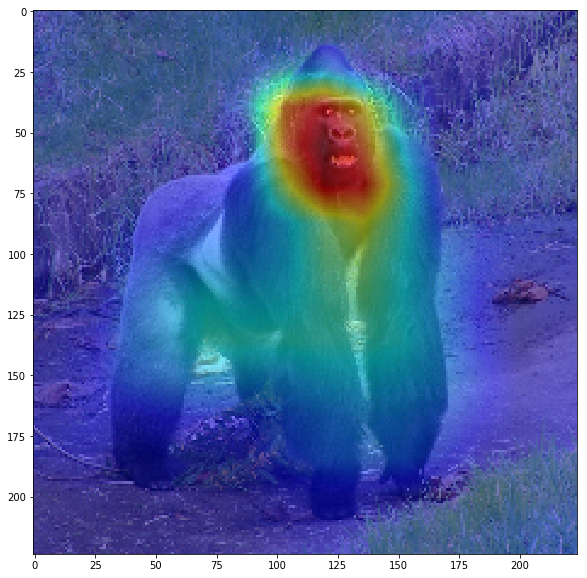

In [6]:

img = cv2.imread('./images/gorilla.jpg') #读取图像
img = np.float32(cv2.resize(img, (224, 224))) / 255 #为了丢到vgg16要求的224*224 先进行缩放并且归一化
input = preprocess_image(img)

mask = grad_cam(input)
show_cam_on_image(img, mask)
